
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
<200 words

Cell 3:

## ***Why?***
<200 words

Cell 4:

## ***How?***
<400 words

Cell 5:

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***
<300 words

In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## What 
The corpus of my final project, according to my current plan, consists of fan fiction scrapped from AO3 (Archive of Our Own) platform. Archive of Our Own is one of the largest nonprofit open-source repositories for fanfiction (fic) and other fan works contributed by users. I am interested in finding the relationship between readers and writers in an open-source environment where writers are motivated mainly by interest instead of profit. Particularly, I want to know the process of social interaction between readers and writers. For example, do readers support the work they like mainly by using “kudos” or leaving comments? Which way motivate the writers more? More specifically, what kind of comment works better, the one expressing a general supportive feeling, or the one that is more specific to the content? And what are the power dynamics of readers and writers? Could readers influence the content of the fiction they like? Will writers feel responsible to cater to the taste of readers or will they just stick to their original ideas?

## Why
Online fiction has become an important part of internet culture and gradually gained public attention and acknowledgment. In 2019, the Archive of Our Own (AO3) was even awarded a Hugo Award, which is one of the most prestigious awards in science fiction. However, studies about online fiction are still limited. We have little clue about the characteristics of online fiction, the relationship between online writers and readers, and the dynamics of reader/writer interactions, etc. And more importantly, how are they different from traditional literary creation.


This study could reflect how ICT changes the process of literary creation and forge a new kind of power dynamics between reader and writer. More generally, the study will also provide a new perspective in understanding collaboration and conversation patterns in the open-source environment, which is widely believed to be the major paradigm in the internet era.nvironment, which is widely believed to be the major paradigm in the internet era.

## How 

The major technique would be word and document embedding. Generally, I'm going to collect 10~20 fanfiction fields (e.g. harry potter fanfiction, a song of ice and fire fanfiction). First of all, I will use word embedding method to describe the general world view of the fanfiction world. After that, I will build several dimensions (e.g., male/female, poor/rich, happy/sad) and project the fanfiction onto these dimensions to see if there's any systematic difference (or similarity) in terms of world view in each fanfiction field (e.g., the ice and fire world should be much darker than harry potter world based on the original work). The second step will be interpreting writer-reader interaction. I will project the fiction onto the dimensions and see if there's any specific pattern that attracts readers (kudos). Moreover, I will also tract the linguistic system between chapters and examine if writers follow patterns that attract more kudos. By doing this in several fanfiction field, I will depict a general picture about the new writer-reader relationship in a online fanfiction platform.

## Pitch Your Sample

The social game in my proposed research is the game of readers and writers in open source, non-profit online fiction platform. The social actors in this game are, again, readers and writers, who interact via comments or kudos. Kudos is a one-direction communication method by which readers could vote for their favorite fiction. Commenting is bi-directional because writers could reply to readers' comments. This abstract social game is closely related to my research question: what is the social relationship between readers and writers? To address the question, the sample design for the proposed research would be to collect all comments and kudos information for randomly selected 500 books in a specific kind of fanfiction (by "kind" I mean the original work which those fanfiction based on). The limitation of the sampling method is that systematic bias could exist. An alternative method might be to randomly choose 500 books from several popular fanfiction kinds. But to scale up the research, the generalization power of this research still needs to increase. Firstly, I need to make sure that any identified patterns are observed because the platform is open source and non-profit. Then, I also need to evaluate whether these potential patterns could exist in other open-source platforms (e.g., Github).

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [69]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [70]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [71]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom"
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [72]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [73]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [74]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [75]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [76]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [77]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('mikew', 0.08265545268171724),
 ('caltech', 0.05464092321093494),
 ('154620', 0.19706119834212132),
 ('wise', 0.05749878121929968),
 ('gsi', 0.07820822067701588),
 ('liquid', 0.0749569030656185),
 ('stylus', 0.10567912764152107),
 ('nj', 0.1109950967372947),
 ('zack', 0.05330795380898169),
 ('miscalculated', 0.21470375597395805),
 ('hire', 0.09901319943986409),
 ('ave', 0.19389877721110985),
 ('sunwrite', 0.1817286448065436),
 ('594', 0.19389877721110985),
 ('passed', 0.33279218254193177),
 ('future', 0.18819404816424326),
 ('antipolis', 0.08243502153417578),
 ('ancestor', 0.1619412292430009),
 ('glossies', 0.13074268623716792),
 ('et', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [78]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [79]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [80]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['future', 'multiple', 'posted', '16', 'compiled', 'buy', 'prog', 'configuration', 'reports', '1993'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [81]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [82]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [83]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [84]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [85]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,category,source_file,text,kmeans_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",0
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,0
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,0
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",0
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,0
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,0
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,0
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",0
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,0
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,0


We can also look at the distinguishing features in each cluster:

In [86]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 thanks
 mac
 just
 does
 drive
 apple
 like
 don
 problem


Cluster 1:
 window
 server
 use
 motif
 using
 widget
 program
 application
 like
 code


Cluster 2:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 dealer


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [87]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [88]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [89]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('rec.autos', 'blue'), ('misc.forsale', 'green'), ('comp.windows.x', 'orange'), ('comp.sys.mac.hardware', 'red')])


Let's plot the data using the true labels as the colors of our data points.

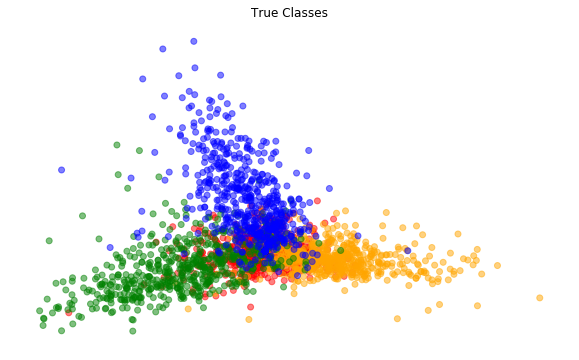

In [90]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

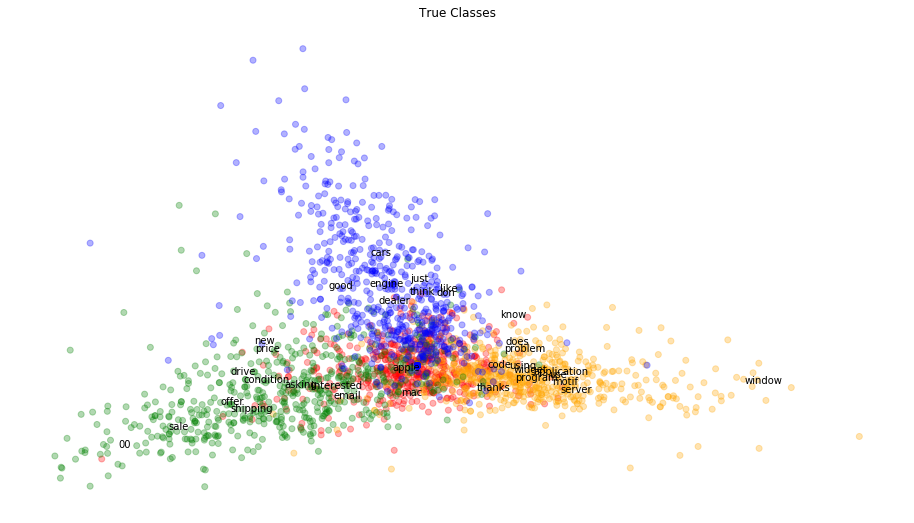

In [91]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [92]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

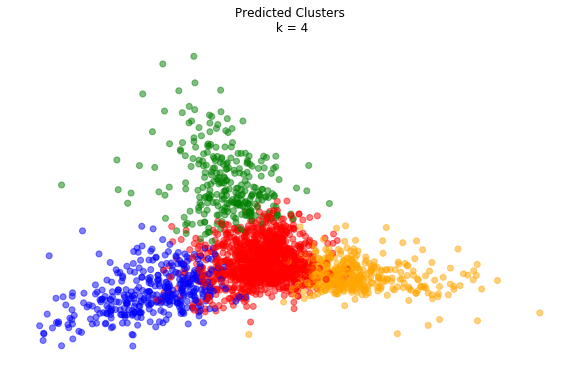

In [93]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [94]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [40]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


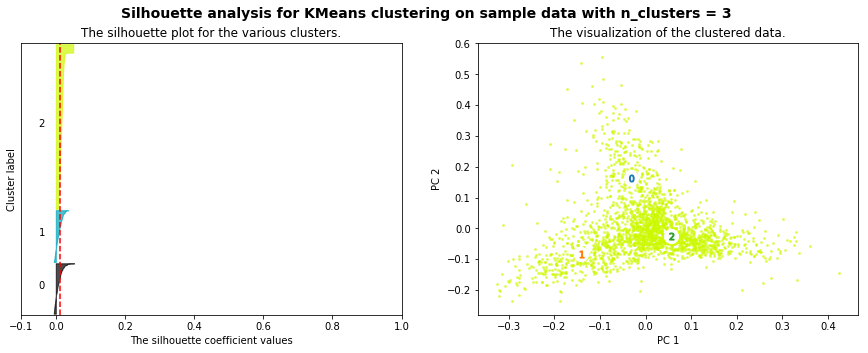

For n_clusters = 3, The average silhouette_score is : 0.013


In [96]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


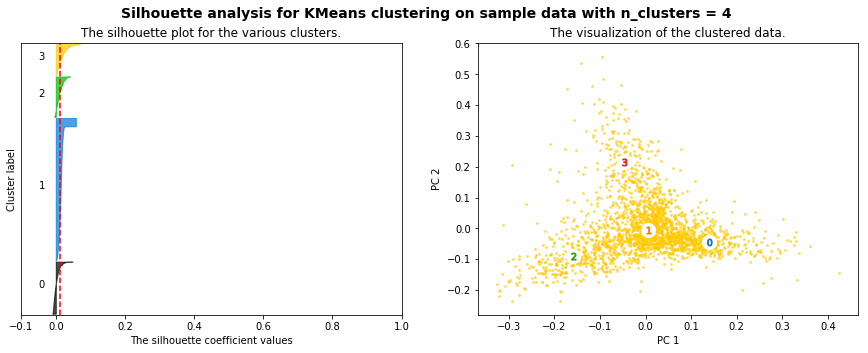

For n_clusters = 4, The average silhouette_score is : 0.012


In [97]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


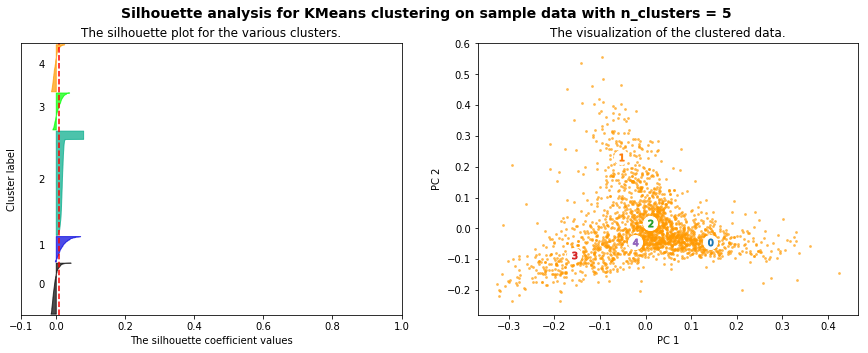

For n_clusters = 5, The average silhouette_score is : 0.010


In [98]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


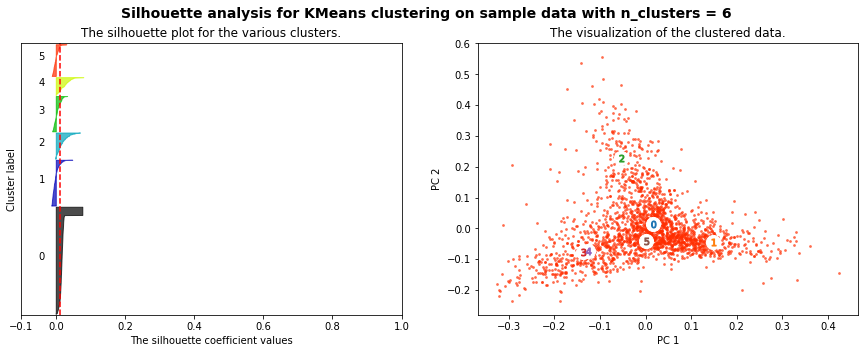

For n_clusters = 6, The average silhouette_score is : 0.011


In [99]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [101]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [102]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [103]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [103]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [104]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [105]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And visualize:

In [106]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

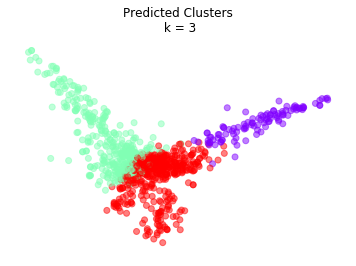

In [107]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [108]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,1
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [12]:
# the corpus consist of 60 fanfiction from 3 different fields: hp, a song of ice and fire, alice in wonderland
data_path="/Users/ziwenchen/Documents/Courses/ContentAnalysis/"
fanfic_df=pandas.read_csv(data_path+"fanfiction.csv")

In [14]:
fanfic_df.head(10)

,Original,Fic_Name,URL,Paragraph,Paragraph-index
0,hp,Wedding Bells,https://archiveofourown.org/works/22915717,"Draco has dreamed of this day for ages, meticu...",0
1,hp,Wedding Bells,https://archiveofourown.org/works/22915717,He is more nervous than he would have thought;...,1
2,hp,Wedding Bells,https://archiveofourown.org/works/22915717,His wedding day — exactly as Draco longed for ...,2
3,hp,Wedding Bells,https://archiveofourown.org/works/22915717,“It’s not too late to elope.” Draco practicall...,3
4,hp,Wedding Bells,https://archiveofourown.org/works/22915717,"“You came.” Draco can hardly believe it, Harry...",4
5,hp,Wedding Bells,https://archiveofourown.org/works/22915717,"Draco knows that he is a coward, that he shoul...",5
6,hp,Wedding Bells,https://archiveofourown.org/works/22915717,“I love you. Of course I came.” The words neve...,6
7,hp,Wedding Bells,https://archiveofourown.org/works/22915717,"Harry loves him, enough to give up his dreams ...",7
8,hp,Wedding Bells,https://archiveofourown.org/works/22915717,Harry deserves better. Draco knows he should l...,8
9,hp,Wedding Bells,https://archiveofourown.org/works/22915717,“See you in front of the altar.”,9


In [15]:
#initialize
ficCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
fictionsVects = ficCountVectorizer.fit_transform(fanfic_df['Paragraph'])
fictionsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(fictionsVects)
fictionsTF = fictionsTFTransformer.transform(fictionsVects)
print(fictionsTF.shape)

(3467, 10591)


In [16]:
list(zip(ficCountVectorizer.vocabulary_.keys(), fictionsTF.data))[:20]

[('draco', 0.1871799018191219),
 ('has', 0.04798863466099668),
 ('dreamed', 0.16609114719897228),
 ('of', 0.12725956297060062),
 ('this', 0.09245652689618943),
 ('day', 0.04288568440257979),
 ('for', 0.14201730009431615),
 ('ages', 0.19366230948921523),
 ('meticulously', 0.23393470430683094),
 ('planned', 0.2093203691997696),
 ('out', 0.19366230948921523),
 ('every', 0.09336206697978111),
 ('tiny', 0.12028890192260495),
 ('detail', 0.05695786352874926),
 ('though', 0.1032134688101561),
 ('he', 0.08723440702525394),
 ('never', 0.11631308899615643),
 ('dared', 0.1871799018191219),
 ('tell', 0.23393470430683094),
 ('harry', 0.12593596992898345)]

We identify words that seem to distinguish this corpus (like draco, harry etc. )

In [21]:
ficTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, 
                                                                 max_features=1000, min_df=3, 
                                                                 stop_words='english', 
                                                                 norm='l2')
fictionTFVects = ficTFVectorizer.fit_transform(fanfic_df['Paragraph'])
print(fictioTFVects.shape)

(3467, 1000)


In [22]:
list(zip(ficTFVectorizer.vocabulary_.keys(), fictionTFVects.data))[:20]

[('draco', 0.3074379599126118),
 ('day', 0.376148173220066),
 ('tiny', 0.29607600017071833),
 ('tell', 0.3721631543814899),
 ('harry', 0.3721631543814899),
 ('wanting', 0.21918407233501808),
 ('mirror', 0.2823679565283539),
 ('heart', 0.3302331321668382),
 ('fast', 0.2592201588596919),
 ('chest', 0.3087074585642543),
 ('nervous', 0.1990524367900264),
 ('thought', 0.19807290834557334),
 ('actually', 0.1687610707894139),
 ('liked', 0.19187834870834092),
 ('flowers', 0.23281746040740178),
 ('agreed', 0.21208862929055583),
 ('change', 0.3485440852899965),
 ('mind', 0.2200661343682227),
 ('wants', 0.21832185907947022),
 ('spend', 0.23035092718531927)]

In [31]:
# K means
def Kmeans(numClusters):
    km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
    km.fit(fictionTFVects)
    fanfic_df['kmeans_predictions'] = km.labels_

    terms = ficTFVectorizer.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(numClusters):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')

In [32]:
# 2 clusters
Kmeans(2)

Top terms per cluster:
Cluster 0:
 like
 just
 eyes
 don
 know
 said
 didn
 did
 time
 jaime


Cluster 1:
 harry
 draco
 ron
 charlie
 eyes
 like
 know
 potter
 hermione
 tsuna




In [33]:
# K means -- 3 clusters
Kmeans(3)

Top terms per cluster:
Cluster 0:
 like
 don
 know
 just
 didn
 did
 want
 sirius
 say
 remus


Cluster 1:
 eyes
 jaime
 head
 hermione
 looked
 said
 time
 right
 door
 hand


Cluster 2:
 harry
 draco
 ron
 charlie
 eyes
 know
 hermione
 like
 potter
 tsuna




In [34]:
# K means -- 4 clusters
Kmeans(4)

Top terms per cluster:
Cluster 0:
 like
 just
 eyes
 didn
 time
 said
 did
 head
 looked
 right


Cluster 1:
 harry
 don
 know
 like
 want
 draco
 charlie
 just
 think
 said


Cluster 2:
 jaime
 brienne
 cersei
 eyes
 hand
 like
 did
 just
 looked
 going


Cluster 3:
 neville
 james
 vine
 snare
 devil
 vines
 eyes
 need
 smirked
 hermione




The ideal cluster should distinguish fiction with different original works. However, none of the clusters seems perfect.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


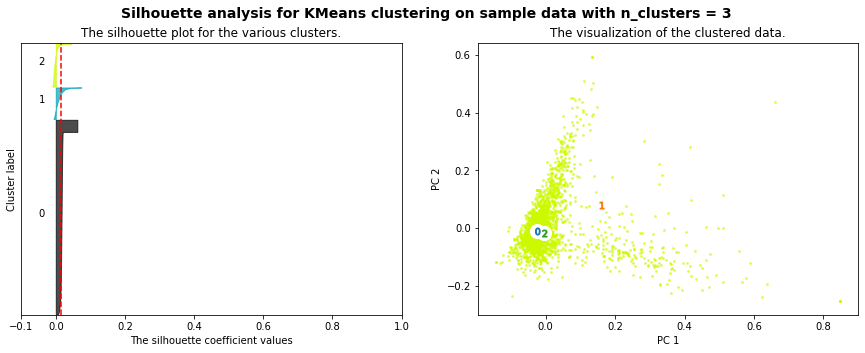

For n_clusters = 3, The average silhouette_score is : 0.014


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


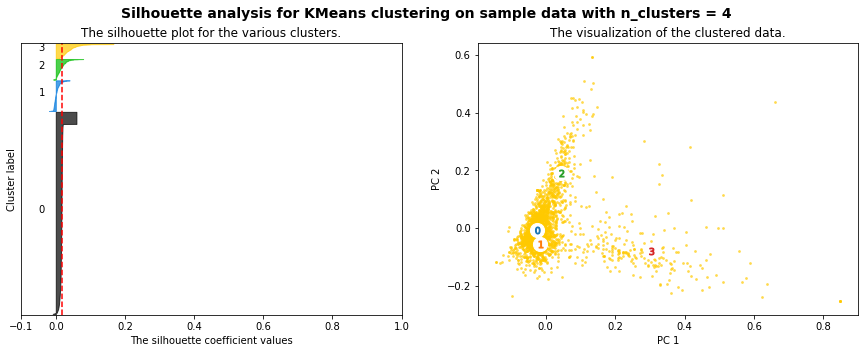

For n_clusters = 4, The average silhouette_score is : 0.017


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


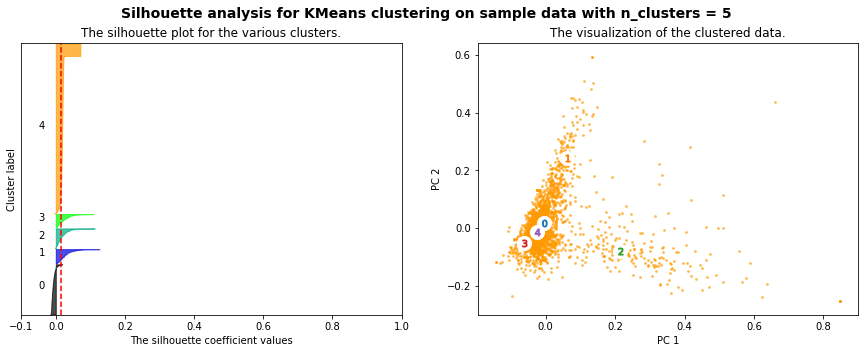

For n_clusters = 5, The average silhouette_score is : 0.016


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


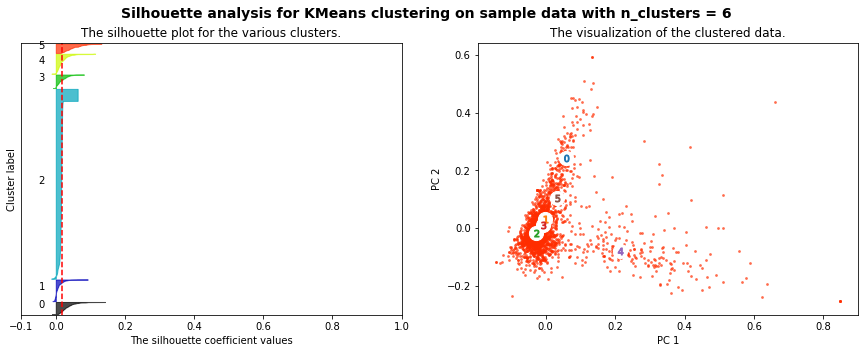

For n_clusters = 6, The average silhouette_score is : 0.018


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


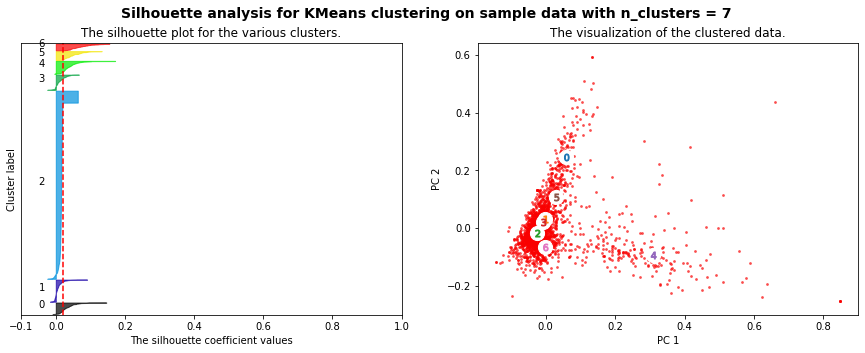

For n_clusters = 7, The average silhouette_score is : 0.020


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


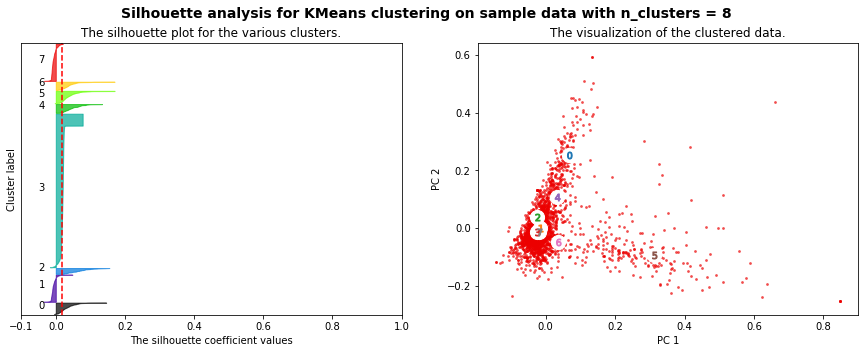

For n_clusters = 8, The average silhouette_score is : 0.019


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


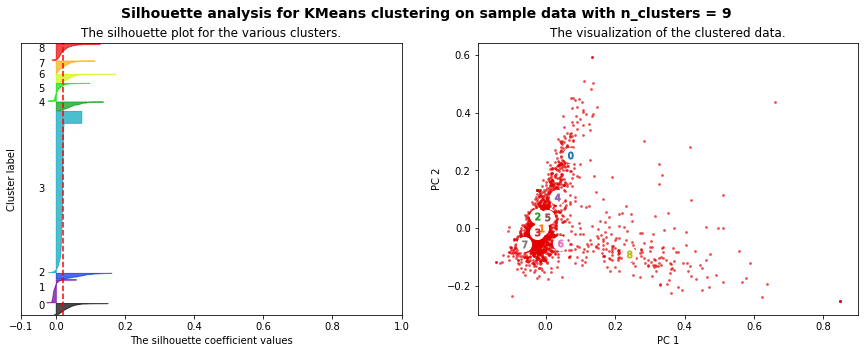

For n_clusters = 9, The average silhouette_score is : 0.021


In [42]:
# Silhouette
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(fictionTFVects.toarray())
reduced_data = pca.transform(fictionTFVects.toarray())
X = fictionTFVects.toarray()
for n in range(3, 10): 
    plotSilhouette(n, X)

The Silhouette score suggests that 9 is the optimal cluster, which is not the case. Such "unsuccessful" cluserting could be because the clustering is based on paragraph, which are relatively short, compared to the entire chapter/book.

In [24]:
# True class
colordict = {
'hp': 'red',
'alice': 'green',
'ice_fire': 'blue',}

colors = [colordict[c] for c in fanfic_df['Original']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('hp', 'red'), ('alice', 'green'), ('ice_fire', 'blue')])


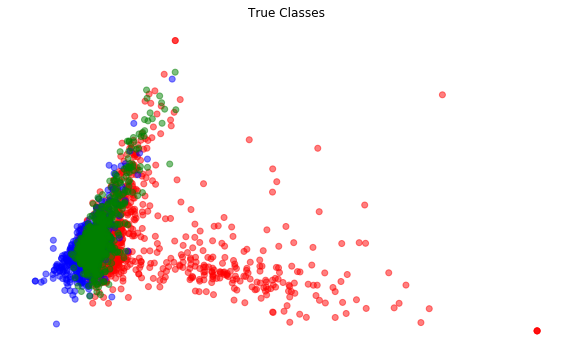

In [36]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

From the above graph, we could see that the true class distribution is not so good, the alice fanfiction and ice and fire fanfiction could barely be distinguished.

In [48]:
fanCategories = ['hp', 'alice', 'ice_fire']

Top terms per cluster:
Cluster 0:
 harry
 neville
 draco
 james
 eyes
 ron
 hermione
 charlie
 know
 did


Cluster 1:
 like
 said
 just
 know
 don
 didn
 looked
 did
 man
 eyes


Cluster 2:
 eyes
 just
 don
 know
 jaime
 didn
 time
 head
 did
 right




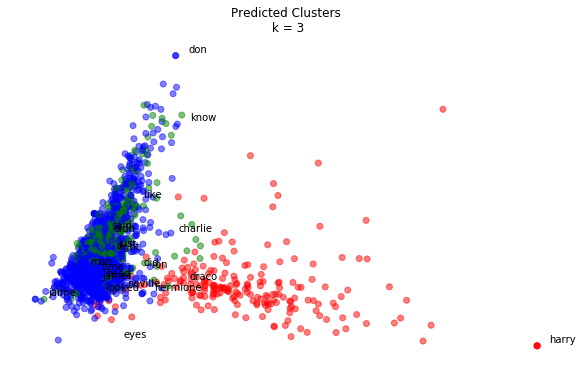

In [49]:
# K = 3
numClusters=3
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(fictionTFVects)
fanfic_df['kmeans_predictions'] = km.labels_

terms = ficTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
    
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

colors_p = [colordict[fanCategories[l]] for l in km.labels_]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

Oh harry, you are so far away... But this further support the distintiveness of hp fanfic. Maybe there are two kind of hp fanfiction in this corpus. 
Generally, the clustering outcome is not so good, maybe I should try to cluster on fiction level.

In [64]:
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(fanfic_df['Original'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(fanfic_df['Original'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(fanfic_df['Original'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(fanfic_df['Original'], km.labels_)))

For our clusters:
Homogeneity: 0.067
Completeness: 0.110
V-measure: 0.083
Adjusted Rand Score: -0.004


# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [109]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [110]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [111]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [112]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [113]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [114]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 43.        ,  45.        ,   0.        ,   2.        ],
       [ 48.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [105.        , 202.        ,   0.37033177,   5.        ],
       [ 19.        , 154.        ,   0.40914841,   2.        ],
       [110.        , 144.        ,   0.44134524,   2.        ],
       [ 12.        , 149.        ,   0.45096656,   2.        ],
       [  1.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [102.        , 146.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

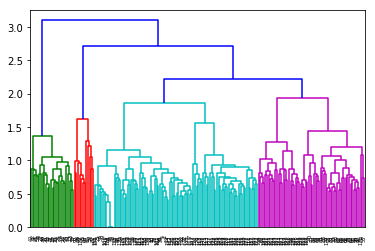

In [115]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

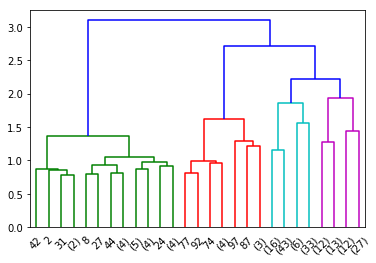

In [116]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [117]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3,
       1, 3, 3, 1, 3, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2,
       3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [118]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [119]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,category,source_file,text,kmeans_predictions,wald_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",0,4
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,0,4
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,0,4
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",0,4
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,0,4
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,0,4
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,0,4
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",0,4
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,0,3
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

And visualize the tree:

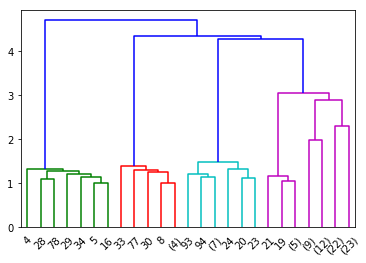

In [121]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [122]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [51]:
groupsCoocMat = fictionTFVects * fictionTFVects.T
groupsCoocMat.setdiag(0)
linkage_matrix = scipy.cluster.hierarchy.ward(groupsCoocMat[:100, :100].toarray())

/Users/ziwenchen/opt/anaconda3/envs/content_analysis/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/ziwenchen/opt/anaconda3/envs/content_analysis/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


approach 1

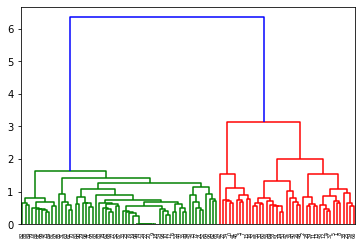

In [52]:
d=scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

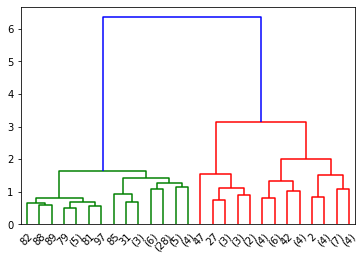

In [53]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

approach 2

In [54]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(groupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 
                                                             4, 'maxclust')

In [56]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(groupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(fanfic_df['Original'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(fanfic_df['Original'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(fanfic_df['Original'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(fanfic_df['Original'], hierarchicalClusters_full)))

/Users/ziwenchen/opt/anaconda3/envs/content_analysis/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.086
Completeness: 0.095
V-measure: 0.090
Adjusted Rand Score: 0.012


In [60]:
fanfic_df['cluster'] = hierarchicalClusters_full
fanfic_df[fanfic_df.cluster==1].head(10)

,Original,Fic_Name,URL,Paragraph,Paragraph-index,kmeans_predictions,cluster
0,hp,Wedding Bells,https://archiveofourown.org/works/22915717,"Draco has dreamed of this day for ages, meticu...",0,0,1
1,hp,Wedding Bells,https://archiveofourown.org/works/22915717,He is more nervous than he would have thought;...,1,0,1
3,hp,Wedding Bells,https://archiveofourown.org/works/22915717,“It’s not too late to elope.” Draco practicall...,3,0,1
4,hp,Wedding Bells,https://archiveofourown.org/works/22915717,"“You came.” Draco can hardly believe it, Harry...",4,0,1
5,hp,Wedding Bells,https://archiveofourown.org/works/22915717,"Draco knows that he is a coward, that he shoul...",5,0,1
7,hp,Wedding Bells,https://archiveofourown.org/works/22915717,"Harry loves him, enough to give up his dreams ...",7,0,1
8,hp,Wedding Bells,https://archiveofourown.org/works/22915717,Harry deserves better. Draco knows he should l...,8,0,1
12,hp,Reflections,https://archiveofourown.org/works/22916086,"“You’ll love it, they’ve done an amazing job o...",2,0,1
15,hp,Reflections,https://archiveofourown.org/works/22916086,Draco also had to admit that the red and mahog...,5,0,1
16,hp,Reflections,https://archiveofourown.org/works/22916086,“What does one do as a professor while it’s st...,6,0,1


In [61]:
fanfic_df[fanfic_df.cluster==2].head(10)

,Original,Fic_Name,URL,Paragraph,Paragraph-index,kmeans_predictions,cluster
2,hp,Wedding Bells,https://archiveofourown.org/works/22915717,His wedding day — exactly as Draco longed for ...,2,1,2
6,hp,Wedding Bells,https://archiveofourown.org/works/22915717,“I love you. Of course I came.” The words neve...,6,2,2
13,hp,Reflections,https://archiveofourown.org/works/22916086,"It wasn’t that Draco was nervous, not exactly....",3,0,2
17,hp,Reflections,https://archiveofourown.org/works/22916086,"“Well, besides getting your office set up and ...",7,2,2
21,hp,Reflections,https://archiveofourown.org/works/22916086,"“Yup, I thought I’d never see it again, but it...",11,2,2
26,hp,Reflections,https://archiveofourown.org/works/22916086,And nothing Draco told himself on that train r...,16,2,2
31,hp,Reflections,https://archiveofourown.org/works/22916086,"“I’m an ex-Death Eater, Potter. If you hadn’t ...",21,1,2
33,hp,Reflections,https://archiveofourown.org/works/22916086,"“I think I’m a tad more than competent, thank ...",23,2,2
36,hp,Reflections,https://archiveofourown.org/works/22916086,"“Just us,” Draco said, his voice cracking. Mer...",26,1,2
39,hp,Reflections,https://archiveofourown.org/works/22916086,Draco looked back at their reflection. They se...,29,2,2


Again, by interrogating the cluster content, it seems that the paragraph structure breaks the fanfiction topic cluster  pattern. This could be because this paragraphs are relatively short and hence large variance in word occurance.

But surprisingly, this metrics actually perform better than Kmeans. This could be because a potential hierachial structure in the corpus (i.e., paragraph--fiction--topic)

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [104]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [105]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [106]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [126]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [127]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [128]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [129]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [130]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(3, 0.97342503)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [131]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [132]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(0, 0.2372416), (2, 0.48075435), (3, 0.2601182)]",0.237242,0.0,0.480754,0.260118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(0, 0.25670612), (2, 0.074774586), (4, 0.1747...",0.256706,0.0,0.074775,0.000000,0.174717,0.227300,0.000000,0.000000,0.263747,0.000000
201,04May2006Kennedy8.txt,"[(2, 0.18525754), (3, 0.7964857), (5, 0.016392...",0.000000,0.0,0.185258,0.796486,0.000000,0.016392,0.000000,0.000000,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(4, 0.3363582), (7, 0.33487502), (8, 0.288408...",0.000000,0.0,0.000000,0.000000,0.336358,0.000000,0.000000,0.334875,0.288408,0.038981
401,08Feb2005Kennedy0.txt,"[(0, 0.23246183), (4, 0.54073346), (6, 0.22170...",0.232462,0.0,0.000000,0.000000,0.540733,0.000000,0.221704,0.000000,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(3, 0.95548904)]",0.000000,0.0,0.000000,0.955489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(0, 0.4027371), (9, 0.57299155)]",0.402737,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.572992
701,13Jun2006Kennedy1.txt,"[(6, 0.8887102), (9, 0.10867957)]",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.888710,0.000000,0.000000,0.108680
801,15Dec2005Kennedy5.txt,"[(2, 0.71216244), (3, 0.052720606), (4, 0.2194...",0.000000,0.0,0.712162,0.052721,0.219456,0.000000,0.014484,0.000000,0.000000,0.000000
901,16May2007Kennedy5.txt,"[(4, 0.38913283), (5, 0.569578)]",0.000000,0.0,0.000000,0.000000,0.389133,0.569578,0.000000,0.000000,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [133]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.00000,0.000000,0.973424,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0.237242,0.00000,0.480754,0.260118,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.845011,0.0,0.000000,0.0,0.000000,0.148858
3,0.000000,0.00000,0.000000,0.971368,0.000000,0.0,0.023263,0.0,0.000000,0.000000
4,0.000000,0.00000,0.997682,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5,0.000000,0.99126,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6,0.424055,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.566705,0.000000
7,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.967543
8,0.777248,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.209109
9,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.967552


First we can visualize as a stacked bar chart:

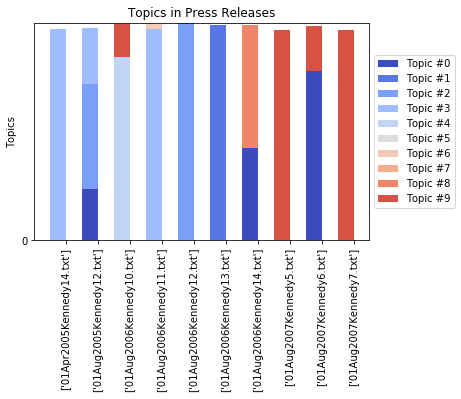

In [134]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

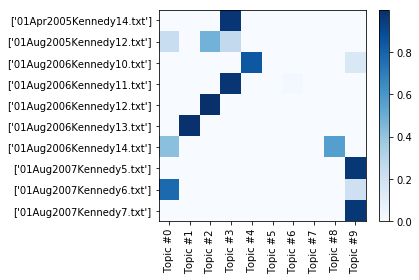

In [135]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [136]:
senlda.show_topic(1)

[('wage', 0.0116434805),
 ('minimum', 0.008390752),
 ('worker', 0.007633167),
 ('fund', 0.0046470957),
 ('tax', 0.0031555935),
 ('ireland', 0.003118962),
 ('chip', 0.0030401899),
 ('fda', 0.002955216),
 ('northern', 0.0028156748),
 ('pension', 0.002781847)]

And if we want to make a dataFrame:

In [137]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,wage,worker,fund,worker,troop,fund,immigration,worker,loan
1,minimum,minimum,fund,worker,head,fund,judge,fund,fund,worker
2,wage,worker,wage,liheap,pension,worker,wage,worker,troop,company
3,worker,fund,loan,cell,fund,teacher,loan,asbestos,unite,fda
4,loan,tax,train,minimum,loan,immigrant,worker,head,wage,fund
5,company,ireland,woman,stem,lender,fail,company,unite,judge,lender
6,attorney,chip,teacher,wage,unite,judge,agency,loan,medicare,aid
7,unite,fda,minimum,food,immigration,soldier,teacher,victim,company,head
8,bankruptcy,northern,employer,victim,agency,sick,science,border,employee,insurance
9,document,pension,pension,winter,company,send,fda,immigrant,iraqi,follow


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

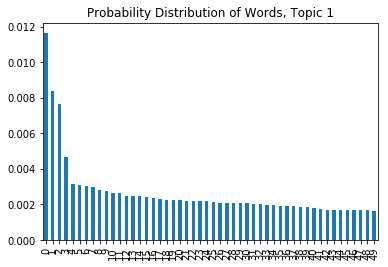

In [138]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [139]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

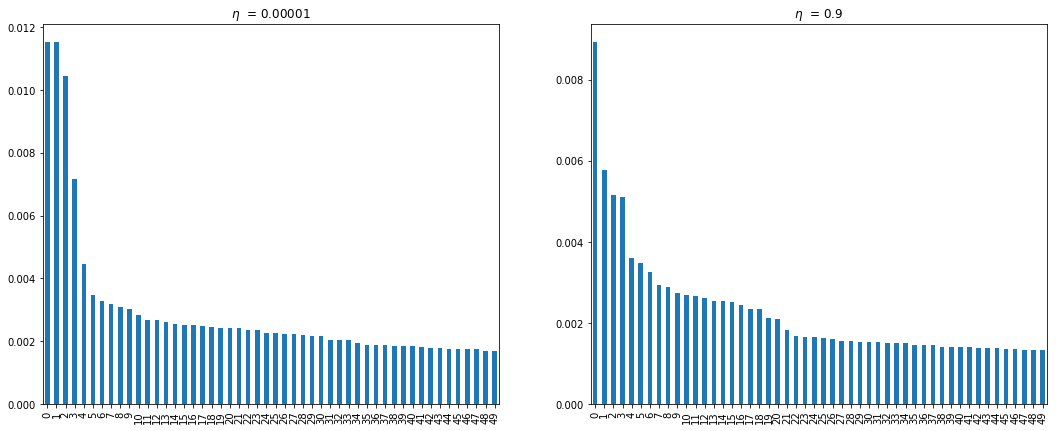

In [140]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

data preprocessing

In [65]:
fanfic_df['tokenized_text'] = fanfic_df['Paragraph'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
fanfic_df['normalized_tokens'] = fanfic_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [90]:
fanfic_book_df=fanfic_df.groupby(['Original','Fic_Name','URL'])['Paragraph']\
.apply(lambda x: " ".join(x)).reset_index()

In [92]:
fanfic_book_df=fanfic_book_df.drop(54)
fanfic_book_df['tokenized_text'] = fanfic_book_df['Paragraph'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
fanfic_book_df['normalized_tokens'] = fanfic_book_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [109]:
fanfic_book_df

,Original,Fic_Name,URL,Paragraph,tokenized_text,normalized_tokens,reduced_tokens
0,alice,A Darker Madness,https://archiveofourown.org/works/20766047,((Disclaimer: Even though this is technically ...,"[Disclaimer, Even, though, this, is, technical...","[disclaimer, technically, fanfiction, adaptati...","[alice, wonderland, certain, finally, alice, a..."
1,alice,A Day in the Life of a Journeyman Apprentince,https://archiveofourown.org/works/22681339,Disclaimer: Alice in Wonderland and Through th...,"[Disclaimer, Alice, in, Wonderland, and, Throu...","[disclaimer, alice, wonderland, look, glass, w...","[alice, wonderland, glass, story, glass, hour,..."
2,alice,Bangtan in Wonderland,https://archiveofourown.org/works/22900264,Taehyung had overworked himself. In the midst ...,"[Taehyung, had, overworked, himself, In, the, ...","[taehyung, overwork, midst, 2nd, world, tour, ...","[young, month, sleep, shower, okay, shut, bath..."
3,alice,Fate and Prophecy,https://archiveofourown.org/works/22242220,The throne room was dark in the dead of the ni...,"[The, throne, room, was, dark, in, the, dead, ...","[throne, room, dark, dead, night, expect, plac...","[throne, dead, expect, soft, fact, castle, bel..."
4,alice,Guillotine Queen,https://archiveofourown.org/works/22147915,"Slice\nThe sleek silver metal, raised, levitat...","[Slice, The, sleek, silver, metal, raised, lev...","[slice, sleek, silver, metal, raise, levitate,...","[silver, metal, queen, watch, cold, trust, lea..."
5,alice,I Can’t Go Back to Yesterday Because I was a D...,https://archiveofourown.org/works/22243384,Bren Aldric Ermendrud was a model student of t...,"[Bren, Aldric, Ermendrud, was, a, model, stude...","[bren, aldric, ermendrud, model, student, solt...","[student, important, fact, mean, course, catch..."
6,alice,John Mulaney in Wonderland,https://archiveofourown.org/works/18621886,John was beginning to get very tired of sittin...,"[John, was, beginning, to, get, very, tired, o...","[john, begin, tire, sit, wall, bodega, nick, l...","[sit, wall, leave, minute, fall, twice, try, r..."
7,alice,Named Inheritance,https://archiveofourown.org/works/22552879,“There will come a day when your heart will la...,"[There, will, come, a, day, when, your, heart,...","[come, day, heart, lie, shatter, fall, apart, ...","[heart, lie, fall, apart, hour, hour, week, mo..."
8,alice,Proof Positive,https://archiveofourown.org/works/21840496,"With the utmost attitude of politeness, Alice ...","[With, the, utmost, attitude, of, politeness, ...","[utmost, attitude, politeness, alice, lean, fo...","[alice, forward, fix, clear, gaze, young, new,..."
9,alice,Roman's Adventure's in Wonderland,https://archiveofourown.org/works/21371008,“Off with his head!” The words echoed down the...,"[Off, with, his, head, The, words, echoed, dow...","[head, word, echo, hall, prince, heart, stride...","[word, hall, prince, heart, different, happen,..."


In [107]:
#initialize
bookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
bookTFVects = bookTFVectorizer.fit_transform(fanfic_book_df['Paragraph'])

In [108]:
# drop missing
fanfic_book_df['reduced_tokens'] = fanfic_book_df['normalized_tokens'].apply(lambda x: dropMissing(x, bookTFVectorizer.vocabulary_.keys()))

create Corpus

In [110]:
dictionary = gensim.corpora.Dictionary(fanfic_book_df['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in fanfic_book_df['reduced_tokens']]

In [112]:
num_topics=3
gensim.corpora.MmCorpus.serialize('book.mm', corpus)
senmm = gensim.corpora.MmCorpus('book.mm')
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                         num_topics=num_topics, alpha='auto', eta='auto')

In [117]:
sen1Bow = dictionary.doc2bow(fanfic_book_df['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(fanfic_book_df['Fic_Name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: A Darker Madness
are: [(2, 0.986083)]


In [118]:
ldaDF = pandas.DataFrame({
        'name' : fanfic_book_df['Fic_Name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in fanfic_book_df['reduced_tokens']]
    })

In [121]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF.head(5)

,name,topics,topic_0,topic_1,topic_2
0,A Darker Madness,"[(0, 0.012759892), (2, 0.9816005)]",0.012760,0.000000,0.981601
1,A Day in the Life of a Journeyman Apprentince,"[(2, 0.9908547)]",0.000000,0.000000,0.990855
2,Bangtan in Wonderland,"[(1, 0.019263163), (2, 0.9731444)]",0.000000,0.019263,0.973144
3,Fate and Prophecy,"[(0, 0.75728136), (2, 0.23977679)]",0.757281,0.000000,0.239777
4,Guillotine Queen,"[(0, 0.06984113), (1, 0.8243577), (2, 0.105801...",0.069841,0.824358,0.105801


In [123]:
# for the first 10 document...they are supposed to be in the same topic..
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(3)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2
0,0.012760,0.000000,0.981601
1,0.000000,0.000000,0.990855
2,0.000000,0.019263,0.973144
3,0.757281,0.000000,0.239777
4,0.069841,0.824358,0.105801
5,0.000000,0.478069,0.517000
6,0.000000,0.374440,0.615884
7,0.412817,0.010030,0.577154
8,0.937801,0.022952,0.039246
9,0.015128,0.299107,0.685764


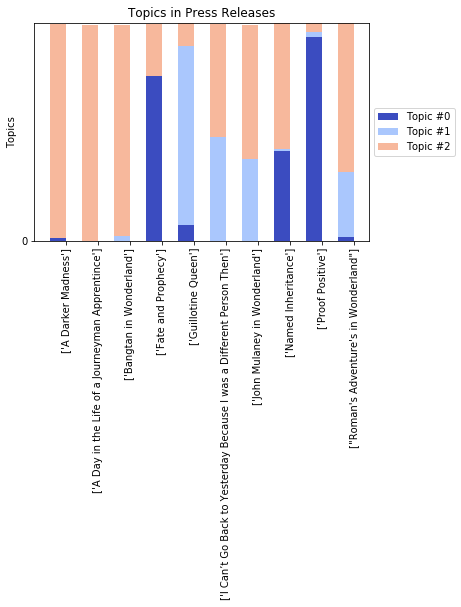

In [124]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()


The first three fiction seems to be mainly topic#2, and hence different from others. But they are all alice in wonderland fanfiction.

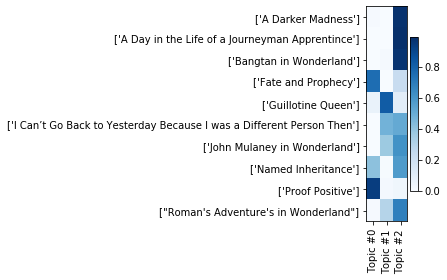

In [125]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [127]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2
0,eye,harry,eye
1,hermione,eye,leave
2,smile,percy,harry
3,jon,jaime,sansa
4,harry,ask,smile
5,brienne,turn,stand
6,leave,leave,turn
7,close,smile,try
8,alice,try,ask
9,year,remus,jon


we could see that fiction do not cluster as we expected (e.g., by orignal fiction)

<Figure size 432x288 with 0 Axes>

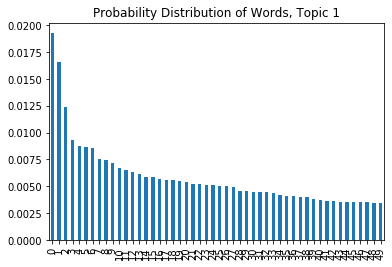

In [128]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

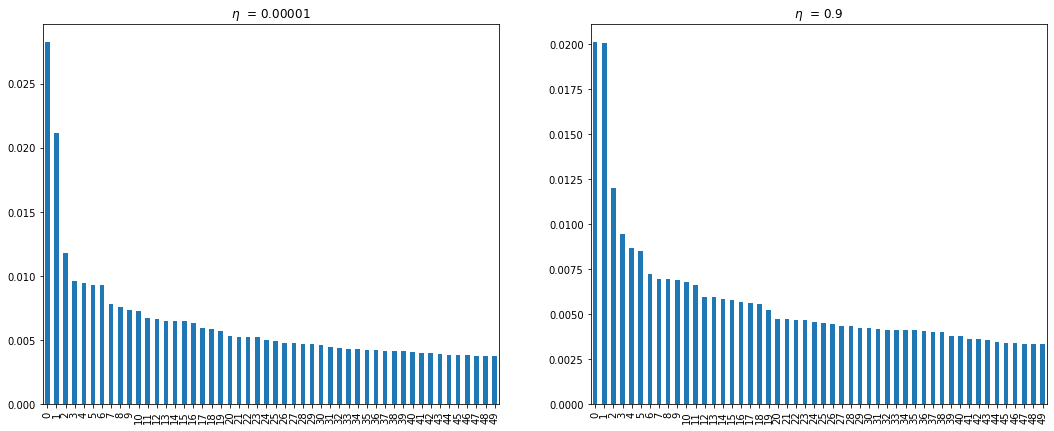

In [129]:
# change eta
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=10, eta = 0.9)

topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

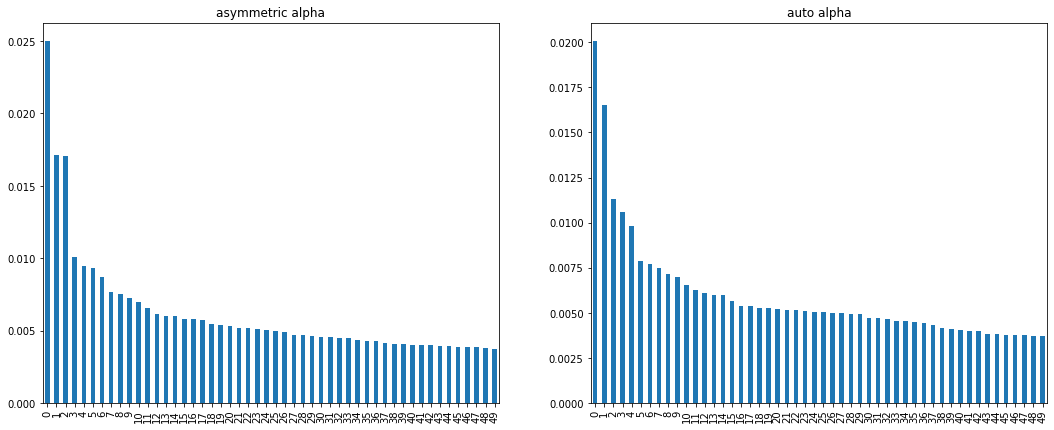

In [130]:
### change alpha
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=10, alpha = "asymmetric")
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=10, alpha = "auto")

topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'asymmetric alpha')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'auto alpha')
plt.show()

In [138]:
# change topic number
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=5, eta = 0.0001)
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,eye,jaime,eye,eye,eye
1,harry,eye,leave,percy,jon
2,smile,brienne,harry,harry,harry
3,sansa,hermione,alice,smile,leave
4,try,leave,smile,turn,turn
5,leave,harry,turn,leave,smile
6,ask,ask,woman,stand,sansa
7,hermione,try,ask,brother,ned
8,father,stand,arm,try,hear
9,turn,sit,potter,meet,sit


In [144]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=6, eta = 0.9)
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF1 = pandas.DataFrame(topicsDict)

senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=6, eta = 0.0001)
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF2 = pandas.DataFrame(topicsDict)
print(wordRanksDF1)
print("\n")
print(wordRanksDF2)

  Topic_0 Topic_1 Topic_2  Topic_3   Topic_4   Topic_5
0     eye     eye   harry      eye       eye     harry
1   jaime   harry     eye      jon     percy    sirius
2     jon   smile   leave    harry  hermione     remus
3   sansa    turn     try    leave     harry       eye
4   smile   leave   sansa    smile     leave  hermione
5   leave   woman     ask      arm      turn     james
6   harry   alice    talk     hear       ask     smile
7    turn   stand   smile   potter    potter     leave
8   watch     ask    girl  brienne     white      year
9    love     try    year      try     queen      hear


  Topic_0   Topic_1   Topic_2 Topic_3 Topic_4   Topic_5
0     eye       eye       eye     eye     eye     harry
1  potter     jaime   brienne   smile     jon       eye
2   leave     harry     jaime   harry   percy     leave
3   harry  hermione      turn   leave   smile  hermione
4   smile       jon       ask   jaime  father      year
5    girl      hear     leave    turn   harry     smile
6

In [148]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=6, alpha = "asymmetric")
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF1 = pandas.DataFrame(topicsDict)

senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=6, alpha = "auto")
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF2 = pandas.DataFrame(topicsDict)

print(wordRanksDF1)
print("\n")
print(wordRanksDF2)

    Topic_0  Topic_1 Topic_2   Topic_3 Topic_4 Topic_5
0     harry      eye     eye       eye   harry     eye
1       eye      jon   leave     harry     eye   queen
2  hermione    smile  sirius  hermione   jaime   white
3     jaime   father   remus     leave   leave    turn
4     smile    leave     ask     percy   smile   leave
5   brienne    percy    talk     smile   alice   smile
6      turn  brother   smile      turn     ask    girl
7      love    jaime    help       try     try     try
8     leave     turn   harry       sit     jon  sirius
9       jon      ask    hold       arm    turn    hear


    Topic_0  Topic_1 Topic_2   Topic_3 Topic_4   Topic_5
0     harry      eye   harry       eye     eye       eye
1       eye    jaime     eye     smile   leave     leave
2     smile    leave     jon     harry   percy     smile
3     remus      jon   sansa      turn     ask       jon
4    sirius      try   leave      fall   smile     woman
5     leave   potter  father  hermione   harry  her

In [150]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=6, eta = 0.0001, alpha = "asymmetric")
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF1 = pandas.DataFrame(topicsDict)

senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=6, eta = 0.09, alpha = "auto")
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF2 = pandas.DataFrame(topicsDict)

print(wordRanksDF1)
print("\n")
print(wordRanksDF2)

    Topic_0  Topic_1   Topic_2   Topic_3 Topic_4 Topic_5
0     harry      eye     harry       jon     eye     eye
1       eye    jaime       eye       eye   harry  potter
2     leave    percy  hermione     smile   jaime   smile
3     smile    leave     smile     leave   sansa     boy
4      year    smile      year       ned    turn   leave
5    sirius  brienne      turn      turn     ask   harry
6       ask    harry     leave    father     try   woman
7      turn    sansa     james      hear   leave     arm
8  hermione     walk   brienne       ask  father   white
9    potter      ask     alice  hermione     sit    turn


  Topic_0   Topic_1   Topic_2   Topic_3 Topic_4  Topic_5
0     eye     harry       eye       eye     eye    jaime
1   smile       eye  hermione       jon   leave      eye
2   leave     percy     smile     leave   smile      jon
3     try      turn      book     harry   harry    sansa
4    turn       ask   brienne       ask  potter  brienne
5   harry       try      turn

Since $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings. Changing $\eta$ and $\alpha$ seems to change the distribution of word for topics (and hence the semantic meanings).

When fine tuning the data, I find that smaller $\eta$ and asymmetric $\alpha$ seems to work better in clarifying the meanings of each topics. Still, high frequency word like "eye","smile" confuses the meaning of each topic. We might not get topoics that we expect, but other topics dimensions.

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [155]:
corpora_address = "/Users/ziwenchen/Documents/Courses/ContentAnalysis/Data/SOAP/"

In [156]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [157]:
import zipfile
import pandas as pd

In [158]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [159]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [160]:
soap_dict = {}

In [161]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [162]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [163]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [164]:
i = 0

In [165]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [166]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [167]:
dool = soap_df['Tokenized Texts'][9]

In [168]:
' '.join(dool[0:1500])

"@!Katherine Any sign of your daddy sweetheart @!Nikki They 'll be here soon @!Katherine They said they 're on their way @!Noah They 're here Daddy 's home @!Nicholas Where 's my boy @!Noah Yea Why are you breathing so funny Daddy @!Nicholas Because I ran all the way here I could n't wait to see you @!Katherine It 's finally over @!Nikki Thank God @!Miguel Congratulations Victoria @!Victoria Thank you Miguel You 're looking at a real hero If it were n't for Ryan Nicholas would n't be here with us @!Katherine You look wonderful Nicholas @!Nicholas I feel wonderful @!Katherine I told you your daddy was coming home @!Noah And you 're never leaving again are you Daddy @!Nicholas That 's right never Oh come on @!Ryan Welcome home Nicholas @!Nicholas Thanks @!Rianna Do n't forget your medication @!Raul No more triple chocolate cake @!Billy Been there done that @!Raul Yeah right @!Billy Hey rough We 're here for you all right @!Raul What 's rough is spending one more minute in this place @!Ri

In [169]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [170]:
import networkx as nx

In [171]:
actor_network = nx.Graph()

In [181]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [182]:
actor_network.nodes

NodeView(('Nikki', 'Victoria', 'Billy', 'Paul', 'Michael', 'Brad', 'Ashley', 'Victor', 'Sharon', 'Jill', 'Jack', 'Neil', 'Phyllis', 'J.T.', 'Lauren', 'Nick', 'Kay', 'Lily', 'Sighs', 'Kevin', 'Daniel'))

In [183]:
i = 0

In [184]:
all_texts = []

In [185]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

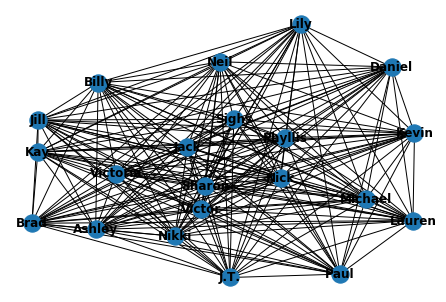

In [186]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [177]:
all_texts[0:10]

[]

In [164]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [165]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [166]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [167]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [168]:
doollda.show_topics()

[(0,
  '0.130*"na" + 0.120*"gon" + 0.090*"be" + 0.042*"love" + 0.028*"wait" + 0.025*"hmm" + 0.021*"say" + 0.018*"mm" + 0.017*"carrie" + 0.016*"mmm"'),
 (1,
  '0.070*"like" + 0.038*"talk" + 0.036*"dad" + 0.033*"time" + 0.032*"try" + 0.027*"chuckle" + 0.025*"be" + 0.023*"look" + 0.023*"listen" + 0.020*"gun"'),
 (2,
  '0.124*"know" + 0.068*"think" + 0.060*"want" + 0.051*"tell" + 0.025*"go" + 0.016*"come" + 0.014*"be" + 0.013*"mean" + 0.013*"happen" + 0.012*"sami"'),
 (3,
  '0.044*"good" + 0.035*"mean" + 0.031*"think" + 0.028*"stefano" + 0.028*"know" + 0.024*"thing" + 0.021*"believe" + 0.020*"like" + 0.017*"way" + 0.015*"lucas"'),
 (4,
  '0.091*"need" + 0.056*"rafe" + 0.053*"help" + 0.030*"course" + 0.029*"leave" + 0.022*"sydney" + 0.022*"test" + 0.021*"bye" + 0.020*"shoot" + 0.020*"ej"'),
 (5,
  '0.133*"yes" + 0.076*"be" + 0.041*"sorry" + 0.037*"get" + 0.026*"know" + 0.020*"well" + 0.014*"feel" + 0.012*"worry" + 0.010*"mean" + 0.010*"glad"'),
 (6,
  '0.063*"john" + 0.059*"stop" + 0.035*"n

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [169]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [170]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.04434908), (1, 0.1636655), (2, 0.17168337), (3, 0.07303326), (5, 0.18090375), (7, 0.16316645), (8, 0.049669832), (9, 0.15352708)]
[(0, 0.04564287), (1, 0.15994014), (2, 0.166935), (3, 0.07172846), (5, 0.18492804), (7, 0.16686365), (8, 0.052410174), (9, 0.15154955)]
[(0, 0.045564834), (1, 0.161894), (2, 0.16576263), (3, 0.068994306), (5, 0.18667614), (7, 0.18113962), (8, 0.048315547), (9, 0.14165114)]
[(0, 0.051611815), (1, 0.1611779), (2, 0.1781671), (3, 0.07053677), (5, 0.1791648), (7, 0.16717589), (8, 0.048152395), (9, 0.14401132)]
[(0, 0.047252756), (1, 0.16661952), (2, 0.17018682), (3, 0.06864313), (5, 0.18384352), (7, 0.16521569), (8, 0.05054304), (9, 0.14769368)]
[(0, 0.046162076), (1, 0.15438502), (2, 0.16620177), (3, 0.07256862), (5, 0.1968395), (7, 0.16062519), (8, 0.053342965), (9, 0.14987314)]
[(0, 0.04524269), (1, 0.16827387), (2, 0.17442298), (3, 0.07023772), (5, 0.1848608), (7, 0.16046369), (8, 0.04732241), (9, 0.1491746)]
[(0, 0.045984045), (1, 0.16086726), (2, 0.

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [198]:
from gensim.matutils import kullback_leibler

In [199]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [173]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

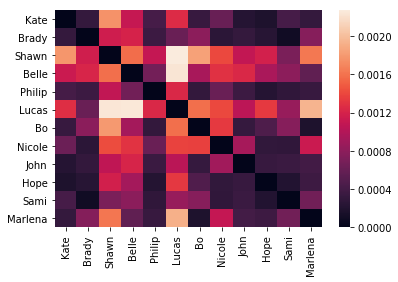

In [174]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [4]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [5]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [6]:
list(coha_texts.keys())[0:5]

['mag_1942_151505.txt',
 'mag_1925_300619.txt',
 'mag_1973_479429.txt',
 'mag_2004_365045.txt',
 'mag_1929_254298.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [7]:
coha_genres = {}
coha_years = {}

In [8]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [9]:
coha_genres.keys()

dict_keys(['nf', 'mag', 'fic', 'news'])

In [10]:
coha_years.keys()

dict_keys(['1979', '2007', '1989', '1893', '1968', '1887', '1931', '1976', '1918', '1815', '1860', '1852', '1953', '1847', '2001', '1901', '1912', '1826', '1883', '1881', '2000', '1853', '1892', '1999', '1867', '1914', '1869', '1898', '1973', '1975', '1839', '2004', '1928', '1814', '1909', '1950', '1840', '1832', '1831', '1819', '1991', '1998', '1955', '1990', '1904', '1871', '1897', '1866', '1994', '1945', '1923', '1829', '1873', '1811', '1978', '1921', '1838', '1825', '1844', '1878', '1907', '1886', '1882', '1995', '1967', '1888', '1925', '1980', '1834', '2006', '1966', '1818', '1992', '1957', '1870', '1939', '1824', '1963', '1900', '1876', '1920', '1910', '1937', '1863', '1948', '1954', '1961', '1880', '1848', '1922', '2008', '1938', '1810', '1817', '1842', '1919', '1851', '1895', '1956', '1891', '1997', '1841', '1983', '1969', '1982', '1959', '1971', '1822', '1865', '1859', '2003', '1924', '1916', '1812', '1947', '1855', '1902', '1885', '1868', '1934', '1827', '1843', '1970', '1930

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [11]:
import collections

In [12]:
years = []
year_lens = []

In [13]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [14]:
years[0], years[-1]

('1810', '2009')

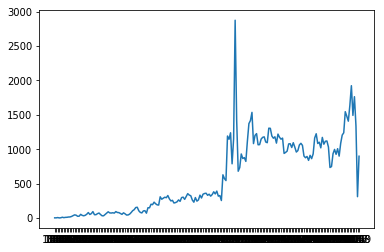

In [15]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [16]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [17]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [18]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [19]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [20]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [41]:
final_corpus= []

In [42]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [43]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [46]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [47]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [48]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [49]:
from gensim.models import ldaseqmodel

In [55]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [64]:
ldaseq.print_topics(time=0)[1]

[('state', 0.009231335276472926),
 ('man', 0.007395542533241843),
 ('great', 0.005407621887489939),
 ('power', 0.00466463108865709),
 ('time', 0.004145275353013492),
 ('government', 0.0038469615335645527),
 ('mr', 0.003784442892543364),
 ('people', 0.0034467994219777665),
 ('law', 0.0034071786078579145),
 ('new', 0.0030027721654430216),
 ('war', 0.002999489239112416),
 ('say', 0.0029620122071219437),
 ('year', 0.0027265764876598106),
 ('country', 0.0026961884570141158),
 ('general', 0.0026385043499987542),
 ('subject', 0.0025921116091278027),
 ('unite', 0.00243013848020865),
 ('interest', 0.0023961925608540803),
 ('mean', 0.002356244385602689),
 ('present', 0.002327481410279418)]

In [65]:
 ldaseq.print_topics(time=4)[1]

[('state', 0.009063458198506274),
 ('great', 0.005281951052175197),
 ('man', 0.0048113539761249395),
 ('power', 0.004484111341699211),
 ('time', 0.004380730260383426),
 ('mr', 0.004363448261206658),
 ('war', 0.0036676379920160007),
 ('government', 0.003660707892751022),
 ('law', 0.003608034898098456),
 ('people', 0.0035690690199701143),
 ('say', 0.0033669920336640846),
 ('new', 0.003254656714598662),
 ('year', 0.0030063559964820033),
 ('right', 0.002722402127793679),
 ('country', 0.0026929936555686994),
 ('unite', 0.0026207546725993914),
 ('president', 0.0026030905455171633),
 ('general', 0.0025967928515510286),
 ('subject', 0.002447981517223704),
 ('office', 0.0024042338715986418)]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [66]:
ldaseq.save("ldaseqmodel")

In [68]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

Since my original corpus does not have timestamp information (or valid way to build social network, as could be shown in the last homework, it's hard to capture the speakers in both party for a conversation), I will just SOAP corpus here.

In [187]:
dool = soap_df['Tokenized Texts'][2]
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1
len(characters)

613

In [206]:
actor_network = nx.Graph()
for character in characters:
    if characters[character] > 1500:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])
actor_network.nodes.data()

NodeDataView({'Bridget': {'lines_spoken': 2181, 'words': []}, 'Rick': {'lines_spoken': 1516, 'words': []}, 'Brooke': {'lines_spoken': 4706, 'words': []}, 'Eric': {'lines_spoken': 1902, 'words': []}, 'Stephanie': {'lines_spoken': 3098, 'words': []}, 'Ridge': {'lines_spoken': 3314, 'words': []}, 'Taylor': {'lines_spoken': 1688, 'words': []}, 'Nick': {'lines_spoken': 2651, 'words': []}, 'Sighs': {'lines_spoken': 1634, 'words': []}})

In [207]:
i = 0
all_texts = []
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

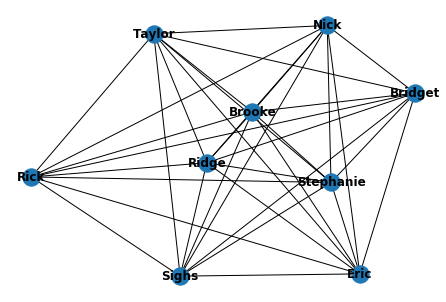

In [208]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [209]:
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, 
                                          num_topics=10, 
                                          alpha='auto', eta='auto')
doollda.show_topics()

[(0,
  '0.056*"want" + 0.055*"like" + 0.045*"know" + 0.038*"feel" + 0.024*"maybe" + 0.021*"well" + 0.020*"believe" + 0.019*"mother" + 0.018*"come" + 0.016*"um"'),
 (1,
  '0.068*"tell" + 0.049*"thank" + 0.036*"work" + 0.032*"think" + 0.028*"oh" + 0.026*"nick" + 0.026*"want" + 0.022*"wrong" + 0.020*"help" + 0.017*"time"'),
 (2,
  '0.055*"think" + 0.048*"love" + 0.038*"get" + 0.035*"stop" + 0.029*"know" + 0.020*"logan" + 0.016*"door" + 0.015*"night" + 0.014*"little" + 0.014*"have"'),
 (3,
  '0.089*"steffy" + 0.049*"let" + 0.038*"good" + 0.037*"hope" + 0.031*"come" + 0.026*"thomas" + 0.023*"hey" + 0.021*"ridge" + 0.020*"forrester" + 0.015*"stay"'),
 (4,
  '0.153*"be" + 0.047*"go" + 0.035*"know" + 0.035*"sorry" + 0.020*"hurt" + 0.019*"sure" + 0.015*"guess" + 0.013*"reason" + 0.013*"thing" + 0.013*"concern"'),
 (5,
  '0.107*"oh" + 0.050*"hope" + 0.031*"god" + 0.024*"know" + 0.020*"find" + 0.018*"sure" + 0.017*"new" + 0.017*"design" + 0.017*"ask" + 0.016*"true"'),
 (6,
  '0.131*"yes" + 0.096*

In [210]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(
        lucem_illud_2020.normalizeTokens(actor_all_words))]

In [211]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(1, 0.30121332), (2, 0.157534), (4, 0.04795041), (5, 0.23036037), (7, 0.25795543)]
[(1, 0.30421767), (2, 0.15528132), (4, 0.046075884), (5, 0.24123757), (7, 0.25149107)]
[(1, 0.30194604), (2, 0.15690926), (4, 0.03948626), (5, 0.2385482), (7, 0.25542232)]
[(1, 0.30038643), (2, 0.16032293), (4, 0.03724282), (5, 0.24135327), (7, 0.2600238)]
[(1, 0.30567846), (2, 0.16475405), (4, 0.03573002), (5, 0.2349731), (7, 0.25807115)]
[(1, 0.30084676), (2, 0.15832159), (4, 0.0402082), (5, 0.23879959), (7, 0.26085266)]
[(1, 0.30507842), (2, 0.15719189), (4, 0.039129134), (5, 0.241554), (7, 0.2555365)]
[(1, 0.30483016), (2, 0.15948795), (4, 0.03972233), (5, 0.2329935), (7, 0.2626979)]
[(1, 0.30519763), (2, 0.15698366), (4, 0.043545324), (5, 0.23451717), (7, 0.2567208)]


Generally, topic 1, 5 and 7 seems to load more than other topics

In [212]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

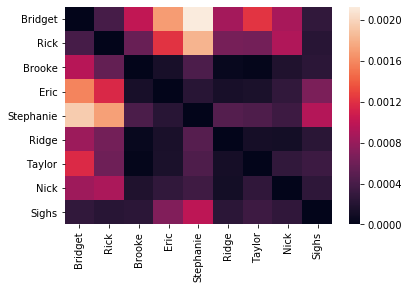

In [213]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [215]:
print(actor_network.nodes['Bridget']['topic_distribution'])
print(actor_network.nodes['Rick']['topic_distribution'])

[(1, 0.30121332), (2, 0.157534), (4, 0.04795041), (5, 0.23036037), (7, 0.25795543)]
[(1, 0.30421767), (2, 0.15528132), (4, 0.046075884), (5, 0.24123757), (7, 0.25149107)]


From the network graph, we could find that characters like characters like Brooke and Ridge are the center of the social interaction (i.e., with high centrality).
Morever, from the KL divergence heatmap we could also see that the topics of Bridget and Rick seems to be quite different compared to other people's word. This is interesting. However, it's hard to tell what make this difference because those topics quite similar by the top words.